In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
# from keras_efficientnets import *
from keras import layers
import tensorflow as tf
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
%matplotlib inline

IMG_SIZE= 256
BATCH_SIZE = 16

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/DR-Data-Blindness_Detection/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DR-Data-Blindness_Detection/test.csv')

In [ ]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

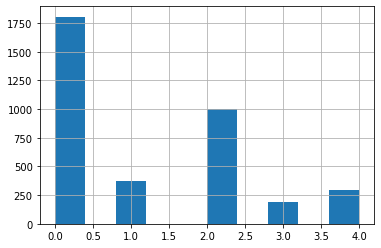

In [ ]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

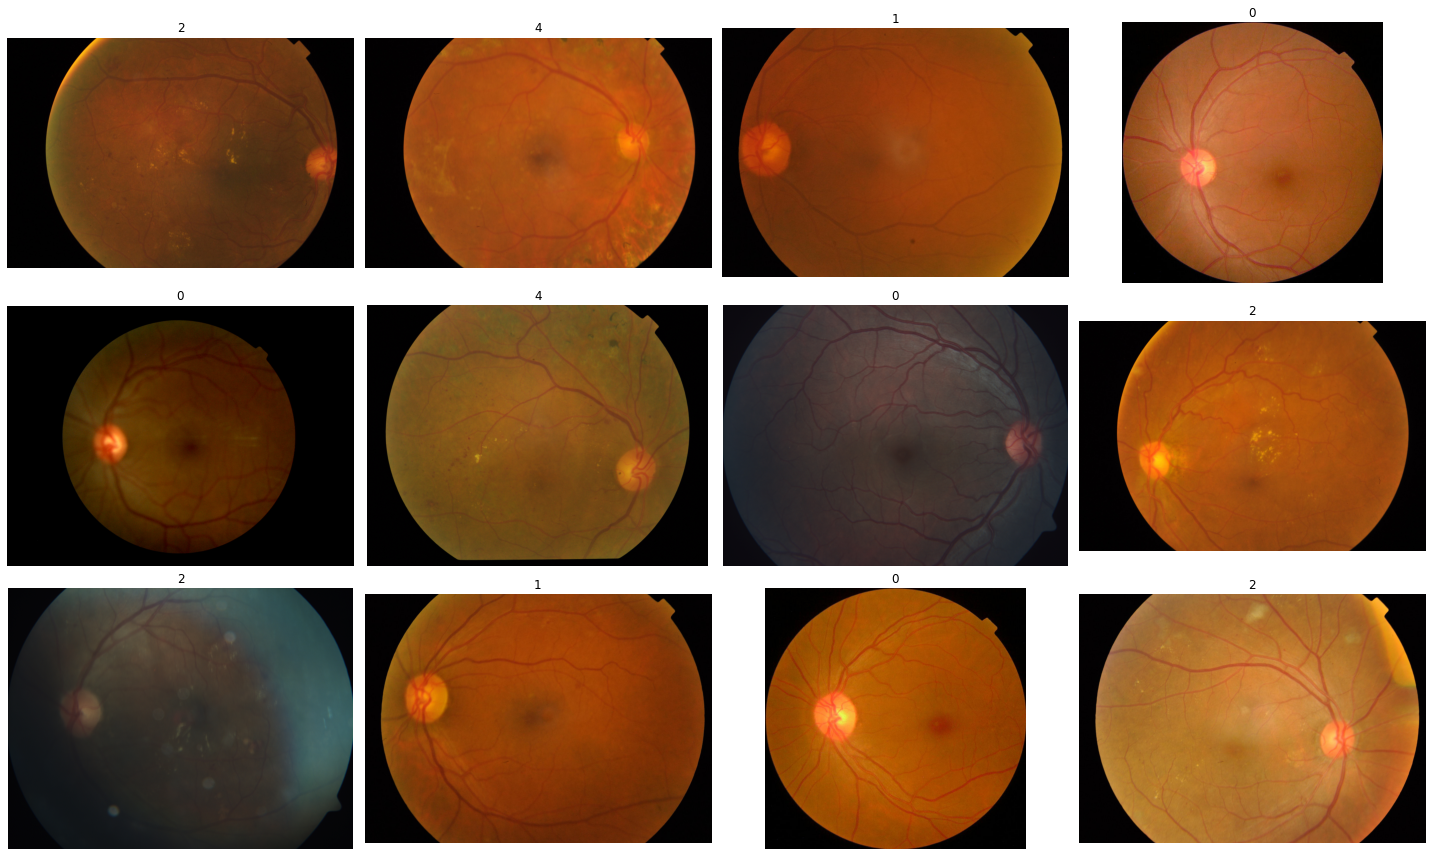

In [ ]:
#Display
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/drive/MyDrive/DR-Data-Blindness_Detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

##Cropping images
We will resize the images to 256x256, then create a single numpy array to hold the data.

In [ ]:
from matplotlib import image
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#     image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image=CLAHEgreen(image)

    return image

def CLAHEgreen(image):
    green=image[:, :, 1]
    clipLimit = 2.0
    tileGridSize = (8,8)
    clahe=cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    cla=clahe.apply(green)
#     cla=clahe.apply(cla)
    img=cv2.merge((cla,cla,cla))

    return img

Histogram

In [ ]:
def get_histograms(df,columns=4, rows=3):
    ax, fig=plt.subplots(columns*rows,figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        plt.subplot(columns, rows, i+1)
        img = cv2.imread(f'/content/drive/MyDrive/DR-Data-Blindness_Detection/train_images/{image_path}.png')
        plt.hist(img.flatten(),256,[0,256],color='r')
#         fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
#         plt.axis('off')
#         plt.imshow(img)

    plt.tight_layout()

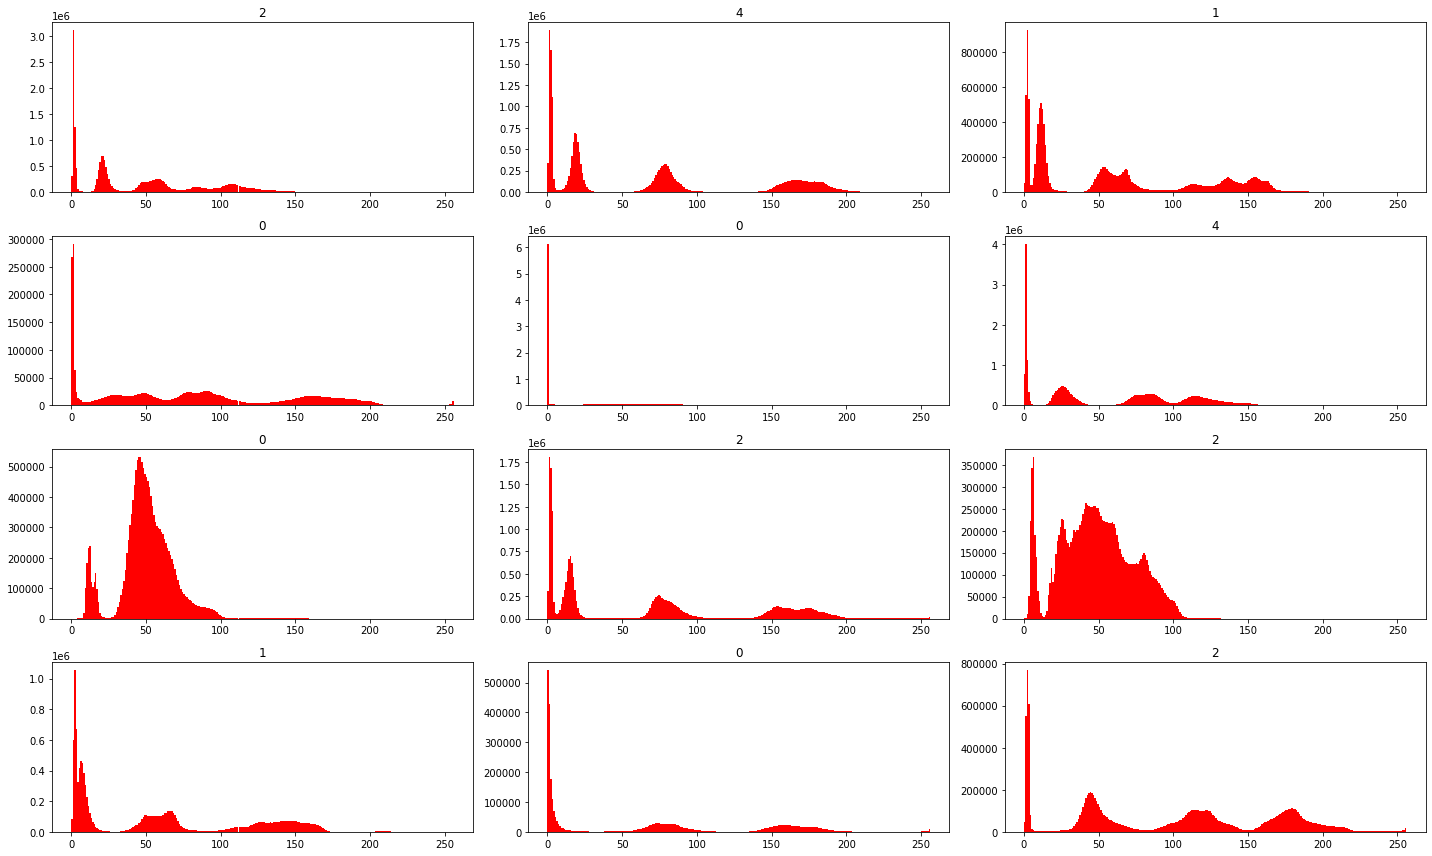

In [ ]:
get_histograms(train_df)

In [ ]:
def get_histograms_preprocess(df,columns=4, rows=3):
    ax, fig=plt.subplots(columns*rows,figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        plt.subplot(columns, rows, i+1)
        img = preprocess_image(f'/content/drive/MyDrive/DR-Data-Blindness_Detection/train_images/{image_path}.png')
        plt.hist(img.flatten(),256,[0,256],color='r')
#         fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
#         plt.axis('off')
#         plt.imshow(img)

    plt.tight_layout()

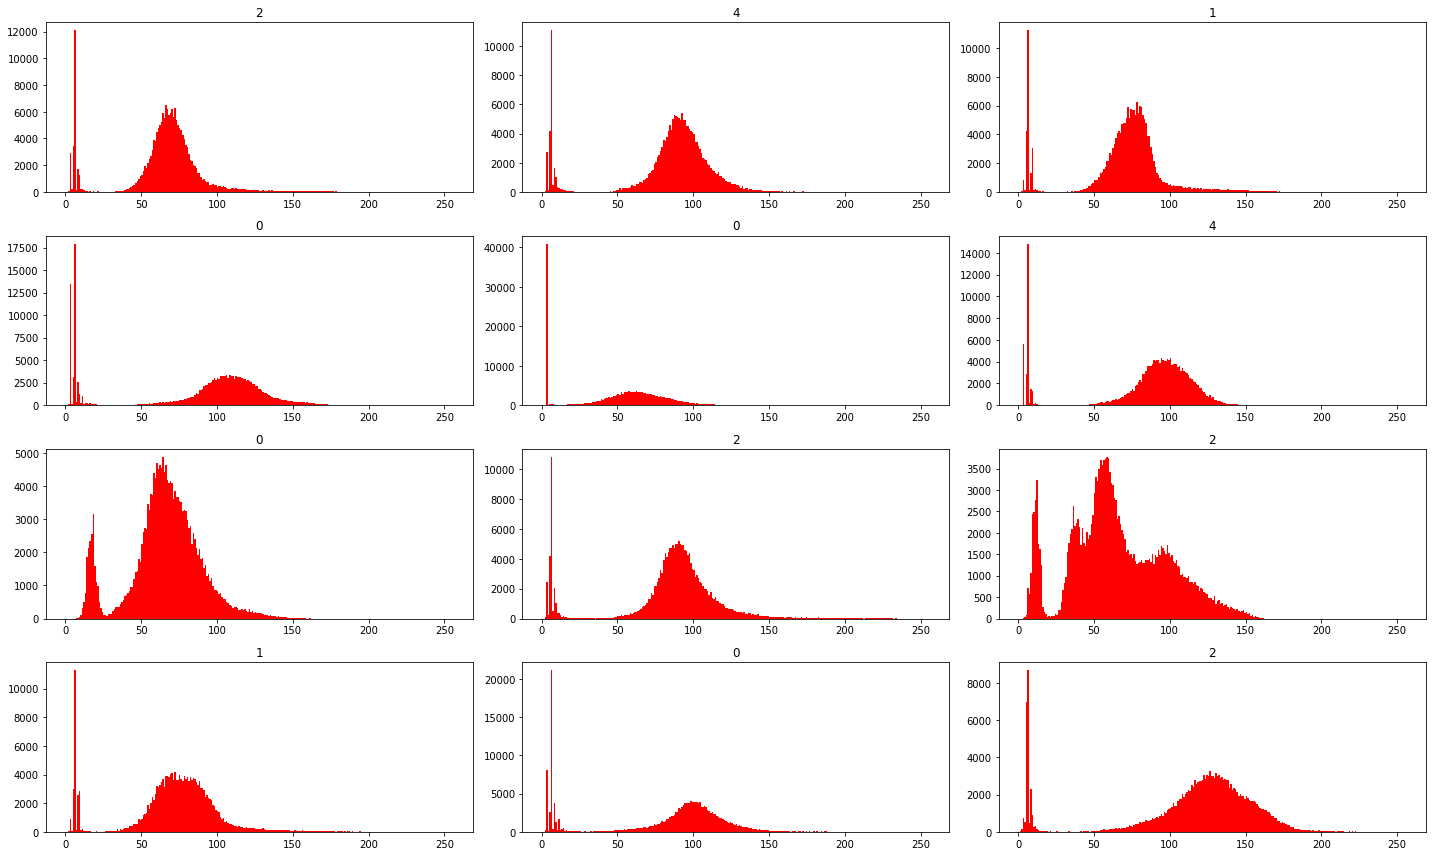

In [ ]:
get_histograms_preprocess(train_df)

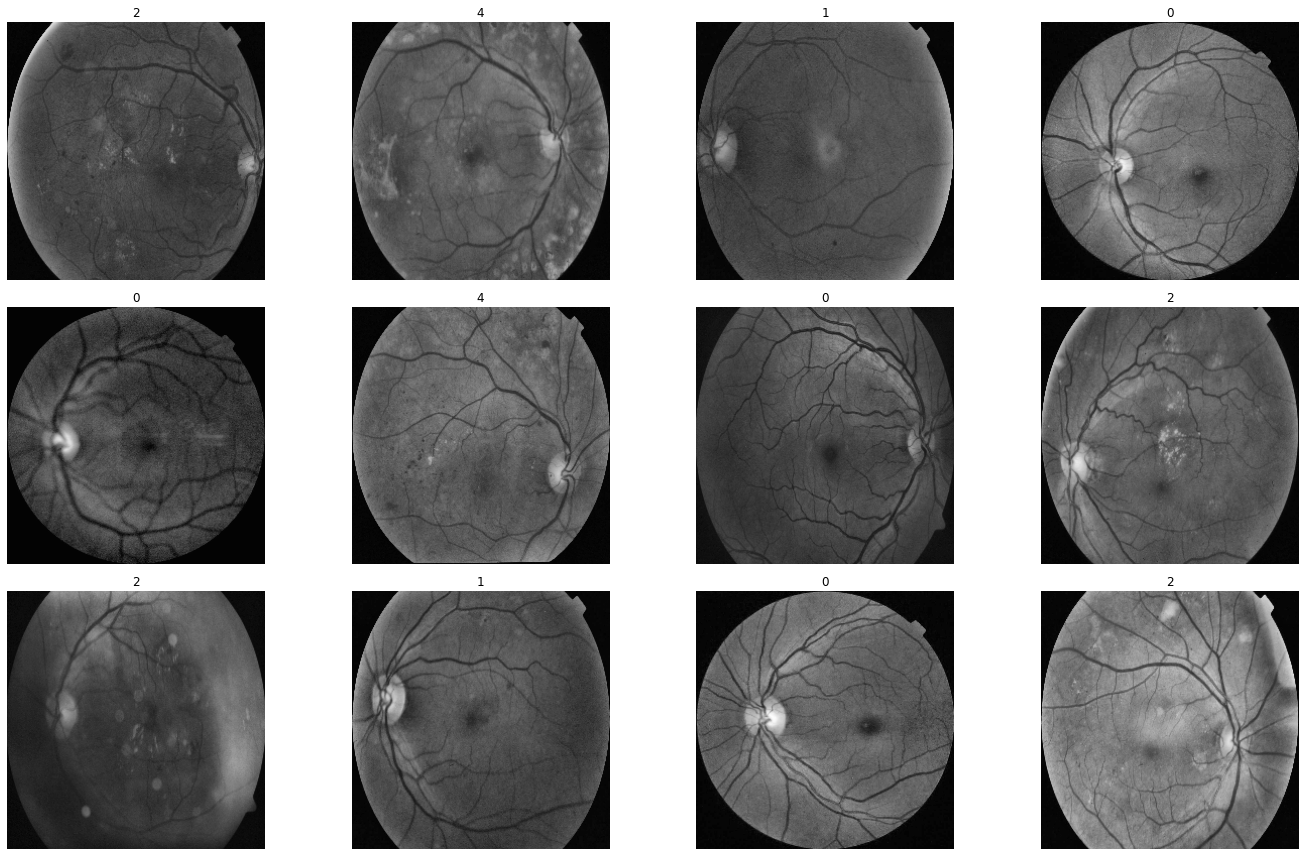

In [ ]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'/content/drive/MyDrive/DR-Data-Blindness_Detection/train_images/{image_path}.png')

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

display_samples_gaussian(train_df)

In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/content/drive/MyDrive/DR-Data-Blindness_Detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [10:55<00:00,  5.58it/s]


In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values


print(y_train.shape)

(3662, 5)


##Creating multilabels
Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be [0, 0, 0, 1], but in our case we will predict [1, 1, 1, 1]

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi,
    test_size=0.15,
    random_state=2019
)

In [ ]:
x_val=x_val/255

In [ ]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

In [ ]:
datagen =  ImageDataGenerator(
        zoom_range=0.6,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# randomly flip images
        rotation_range=360,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255
    )

In [ ]:
data_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

##Quadratic Weighted Kappa

Creating keras callback for QWK

method 1

In [ ]:
import keras
import tensorflow
class Metrics(Callback):

    def __init__(self, validation_data, batch_size = 20):
        super().__init__()
        self.validation_data = validation_data
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        print(self.validation_data)
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):

        batches = len(self.validation_data)
        total = batches * self.batch_size

        val_pred = np.zeros((total,1))
        val_true = np.zeros((total))

        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch+1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()


        _val_kappa = cohen_kappa_score(
            y_val,
            val_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            model.save_weights('/content/EFFB5_model.h5')
            model_json = model.to_json()
            with open('model.json', "w") as json_file:
                json_file.write(model_json)
            json_file.close()

        return

method 2

In [ ]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):

        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            model.save_weights('/content/EFFB5_model.h5')
            model_json = model.to_json()
            with open('model.json', "w") as json_file:
                json_file.write(model_json)
            json_file.close()

        return

method 3

In [ ]:
class Metrics(Callback):

    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []

    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/EFFB5_model.h5')

        return

method 4

In [ ]:
# borrowed from https://www.kaggle.com/mathormad/aptos-resnet50-baseline
class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/EFFB5_model.h5')

In [ ]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 32
checkpoint = ModelCheckpoint('../working/EffB5_.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


In [ ]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)

            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('/content/EffB5_qwk.h5')

qwk = QWKEvaluation(validation_data= y_val,
                    batch_size=batch_size, interval=1)

##Model : EfficientNetB5

In [ ]:
from keras.applications.efficientnet import EfficientNetB5

In [ ]:
efficient = EfficientNetB5(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

In [ ]:
#efficient.load_weights('/content/efficientnet-b5_imagenet_1000_notop.h5')

In [ ]:
def build_model():
    model = Sequential()
    model.add(efficient)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 8, 8, 2048)       28513527  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 28,523,772
Trainable params: 28,351,029
Non-trainable params: 172,743
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Training and Evaluation

In [ ]:
kappa_metrics = Metrics()
est=EarlyStopping(monitor='val_loss',patience=5, min_delta=0.005)
call_backs=[est,kappa_metrics]

history = model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    validation_data=(x_val,y_val),
    epochs=1,
    callbacks=call_backs)

TypeError: ignored

In [ ]:
model.load_weights('/content/EFFB5_model.h5')

test_pred=[]

for i,img_code in enumerate(tqdm(test_df['id_code'])):
    img=preprocess_image(f'/content/drive/MyDrive/DR-Data-Blindness_Detection/test_images/{img_code}.png')
    pred=model.predict(img[np.newaxis]/255)>0.5
    pred=pred.astype(int).sum(axis=1) - 1
    test_pred.append(pred)

In [ ]:
test_pred=np.concatenate(test_pred,axis=0)
test_pred=pd.Series(test_pred)
test_df['diagnosis'] = test_pred
test_df.to_csv('submission.csv',index=False)
print(test_df.head())

In [ ]:
dist = (test_df.diagnosis.value_counts()/len(test_df))*100
print('Prediction distribution:')
print(dist)
test_df.diagnosis.hist()
plt.show()